<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/main/tim-grad-cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install pydicom -q

     |████████████████████████████████| 2.0 MB 7.6 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/capstone/assets/stage_2_train_images.zip'

!unzip {path}
!reset

In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision
from torchvision.models import densenet121

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os

import pydicom as dicom
from PIL import Image
import cv2

In [8]:
model_package = torch.load('/content/drive/MyDrive/capstone/models/tim-densenet-121-ft', map_location='cpu')
annotations_file = '/content/drive/MyDrive/capstone/assets/stage_2_train_labels.csv.zip'

test_ix = model_package['train_ix']
model_state_dict = model_package['model_state_dict']
optimizer_state_dict = model_package['optimizer_state_dict']

label_df = pd.read_csv(annotations_file).iloc[test_ix]

In [10]:
class CustomImageDataset(Dataset):
  def __init__(self, img_dir, transform=None):
    self.img_dir = img_dir
    self.transform = transform

  def __getitem__(self, patient_id):
    img_path = ''.join([self.img_dir, '/', patient_id, '.dcm'])
    
    image = dicom.dcmread(img_path)
    image = Image.fromarray(image.pixel_array).convert(mode='RGB')

    if self.transform:
        image = self.transform(image)

    return image

In [11]:
image_dir = '/content/'

mean = [0.5132, 0.5132, 0.5132]
std = [0.2168, 0.2168, 0.2168]

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

dataset = CustomImageDataset(image_dir, transform=transform)

In [38]:
class DenseNet(nn.Module):
    def __init__(self, pretrained_model):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = pretrained_model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1024))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [39]:
model = densenet121(weights=None)
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, 1)
)
_ = model.load_state_dict(model_state_dict)

model = DenseNet(model)

Age 60
Sex M
Densnet predicted correctly? True


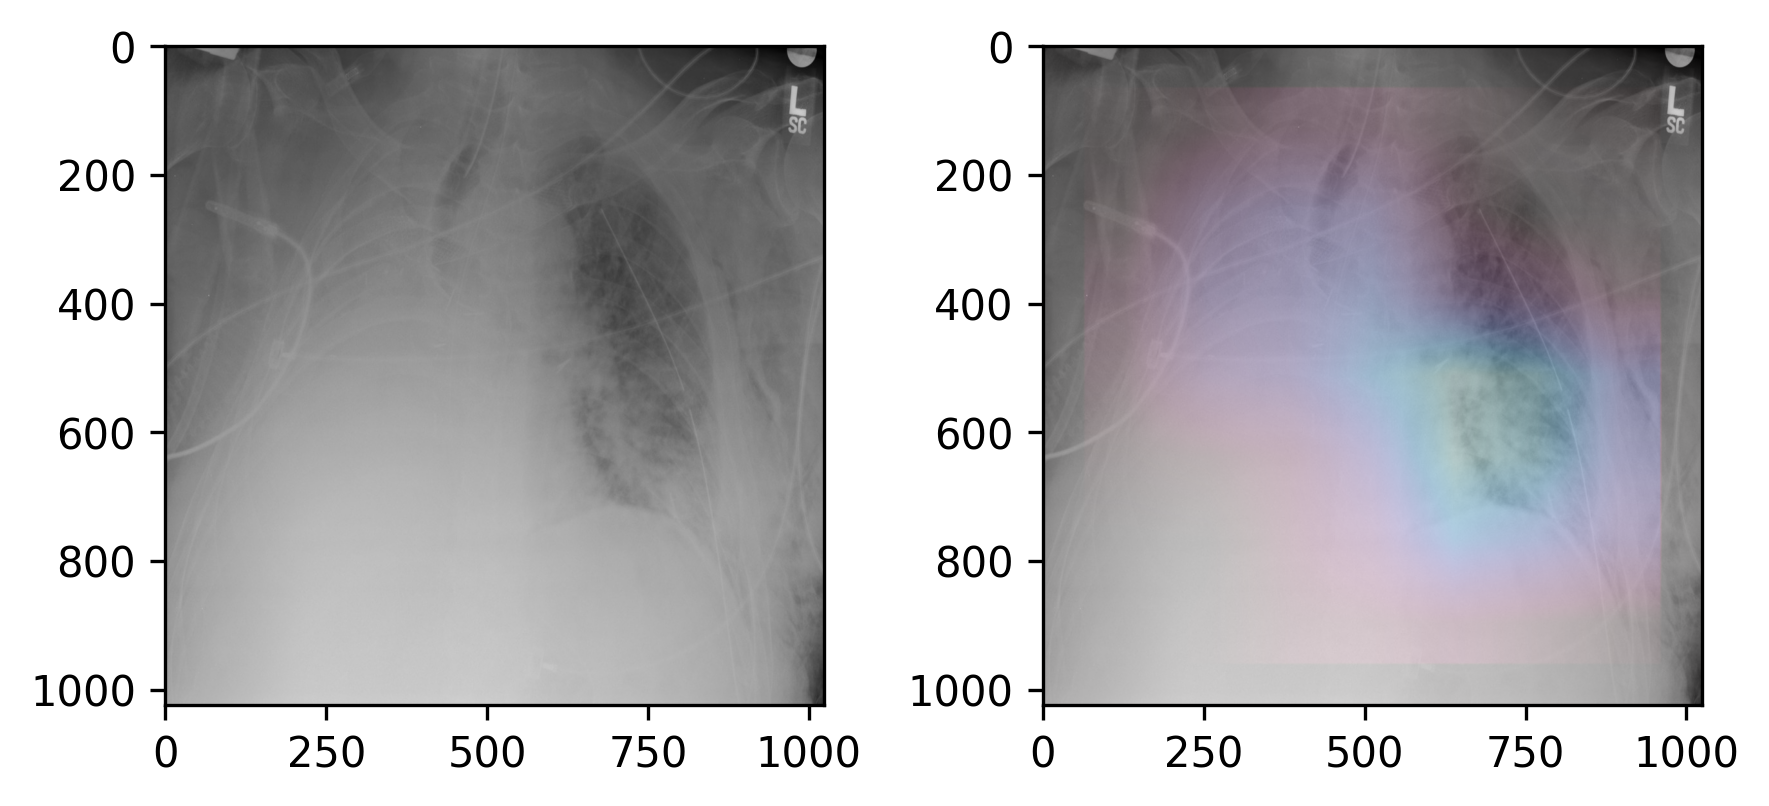

In [120]:
def show_gradcam(model, patient, target):
  model.eval()
  img = dataset[patient.patientId].unsqueeze(dim=0).cpu()
  pred = model(img)
  pred[:, 0].backward()
  y_hat = int(pred.item() >= 0.0)
  # pull the gradients out of the model
  gradients = model.get_activations_gradient()

  # pool the gradients across the channels
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  # get the activations of the last convolutional layer
  activations = model.get_activations(img).detach()
  # weight the channels by corresponding gradients
  for i in range(pooled_gradients.shape[0]):
      activations[:, i, :, :] *= pooled_gradients[i]
      
  # average the channels of the activations
  heatmap = torch.mean(activations, dim=1).squeeze()

  # relu on top of the heatmap
  # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
  heatmap = np.maximum(heatmap, 0)
  # normalize the heatmap
  heatmap /= torch.max(heatmap)

  img_path = ''.join([image_dir, '/', patient.patientId, '.dcm'])
  
  image = dicom.dcmread(img_path)
  
  print('Age', image.PatientAge)  
  print('Sex', image.PatientSex)
  print('Densnet predicted correctly?', y_hat == target)

  heatmap_x = cv2.resize(heatmap.numpy(), (224, 224))
  heatmap_x = np.pad(heatmap_x, 16)
  heatmap_x = cv2.resize(heatmap_x, (image.pixel_array.shape[1], image.pixel_array.shape[0]))
  heatmap_x = np.uint8(255 * heatmap_x)
  heatmap_x = cv2.applyColorMap(heatmap_x, cv2.COLORMAP_INFERNO)

  image = cv2.cvtColor(image.pixel_array,cv2.COLOR_GRAY2RGB)
  img_x = cv2.addWeighted(image, 1.0, heatmap_x, .2, 1.0)

  fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=300)
  ax1.imshow(image)
  ax2.imshow(img_x)
  fig.tight_layout()
  plt.show()

target = 1
patient = label_df[label_df.Target==target].iloc[79]

show_gradcam(model, patient, target)

NameError: ignored